In [1]:
"""Imports"""

from astropy.io import fits, ascii
from astropy.table import Table
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from astropy.wcs import WCS
from astropy import units as au
from astropy import stats
import scipy as sp
from scipy import ndimage
from spectral_cube import SpectralCube

import aplpy

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

In [2]:
"""Load data"""

datapath = '/Users/ashleybarnes/Dropbox/work/Smallprojects/galaxies/ngc1672'

# HST Ha data 
inputfile = '%s/hst_contsub/550m814w/ngc1672_halpha_final.fits' %datapath
hdu = fits.open(inputfile)[0]
# hdu_all = fits.open(inputfile)[0]

# HST cont data
inputfile = '%s/hst_contsub//550m814w/ngc1672_cont.fits' %datapath
hdu_cont = fits.open(inputfile)[0]

# MUSE Ha data
inputfile = '%s/data/muse/NGC1672-0.96asec_MAPS.fits' %datapath
hdu_muse = fits.open(inputfile)[1]

# MUSE nebula catalouge mask data
inputfile = '%s/data/muse/NGC1672_nebulae_mask_V2.fits' %datapath
hdu_nebcat = fits.open(inputfile)[0]

In [8]:
"""Cut out test region - using spectral cube because thats easy"""

def get_cropmap(hdu_, region):

    hdu_tmp = hdu_.copy() #Creating dummy file
    hdu_tmp.data = [hdu_tmp.data, hdu_tmp.data]

    hdu_tmp.header['CDELT3'] = 1
    hdu_tmp.header['CRPIX3'] = 1
    hdu_tmp.header['CRVAL3'] = 1
    hdu_tmp.header['CUNIT3'] = 'km/s'
    hdu_tmp.header['CTYPE3'] = 'VELO'

    cube = SpectralCube.read(hdu_tmp)
    cube = cube.subcube_from_ds9region(region)
    
    shape_old = cube.hdu.shape
    minax = np.nanmin(shape_old[1:])
    cube = cube[:,0:minax,0:minax]
    
    hdu_tmp = cube.hdu 
    hdu_tmp.data = hdu_tmp.data[0]
    del hdu_tmp.header['*3']
    hdu_tmp.header['WCSAXES'] = 2

    shape_new = hdu_tmp.shape
    print('[INFO] Croppig to square (needed for clumpfind)')
    print('[INFO] Shape: [%s,%s] ---> [%s,%s]' %(shape_old[0], shape_old[1], shape_new[0], shape_new[1]))
    hdu_= hdu_tmp
    
    return(hdu_, cube)

def get_masksaturated(hdu, cube, regfile='./saturatedregions.reg'):

    from regions import Regions
    from astropy.coordinates import Angle, SkyCoord
    
    wcs = WCS(hdu.header)
    scm = cube.spatial_coordinate_map
    skycoord = SkyCoord(scm[1], scm[0])

    regions = Regions.read(regfile, format='ds9')
    nreg = len(regions)
    print('[INFO] Number of regions to remove: %i' %nreg)

    mask = 0
    for i in range(nreg):
        if i == 0: 
            mask = regions[i].contains(skycoord, wcs)
        else: 
            mask += regions[i].contains(skycoord, wcs)

    cube = cube.with_mask(~mask)
#     cube[0].quicklook()

    hdu_tmp = cube.hdu 
    hdu_tmp.data = hdu_tmp.data[0]
    del hdu_tmp.header['*3']
    hdu_tmp.header['WCSAXES'] = 2
    hdu_= hdu_tmp

    return(hdu_)

"""Define test region -- DS9 format"""
# region = 'fk5; box(4:45:46.9964,-59:14:05.280,17.796",36.932",0)' 
region = 'fk5; box(4:45:46.4049,-59:14:02.789,42.391",42.391",359.99999)'
""""""

hdu, cube = get_cropmap(hdu, region)
hdu = get_masksaturated(hdu, cube)

hdu_muse, cube = get_cropmap(hdu_muse, region)
hdu_nebcat, cube = get_cropmap(hdu_nebcat, region)

[INFO] Croppig to square (needed for clumpfind)
[INFO] Shape: [2,1069] ---> [1069,1069]
[INFO] Number of regions to remove: 3
[INFO] Croppig to square (needed for clumpfind)
[INFO] Shape: [2,212] ---> [211,211]
[INFO] Croppig to square (needed for clumpfind)
[INFO] Shape: [2,212] ---> [211,211]


In [9]:
# Save file
hdu.writeto('./ngc1672_hst_cutout.fits', overwrite=True)
hdu_muse.writeto('./ngc1672_muse_cutout.fits', overwrite=True)
hdu_nebcat.writeto('./ngc1672_nebcat_cutout.fits', overwrite=True)

INFO: Auto-setting vmin to -6.223e-19 [aplpy.core]
INFO: Auto-setting vmax to  8.043e-18 [aplpy.core]
INFO: Auto-setting vmin to -1.852e+01 [aplpy.core]
INFO: Auto-setting vmax to -1.558e+01 [aplpy.core]
INFO: Auto-setting vmin to  2.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.562e+03 [aplpy.core]


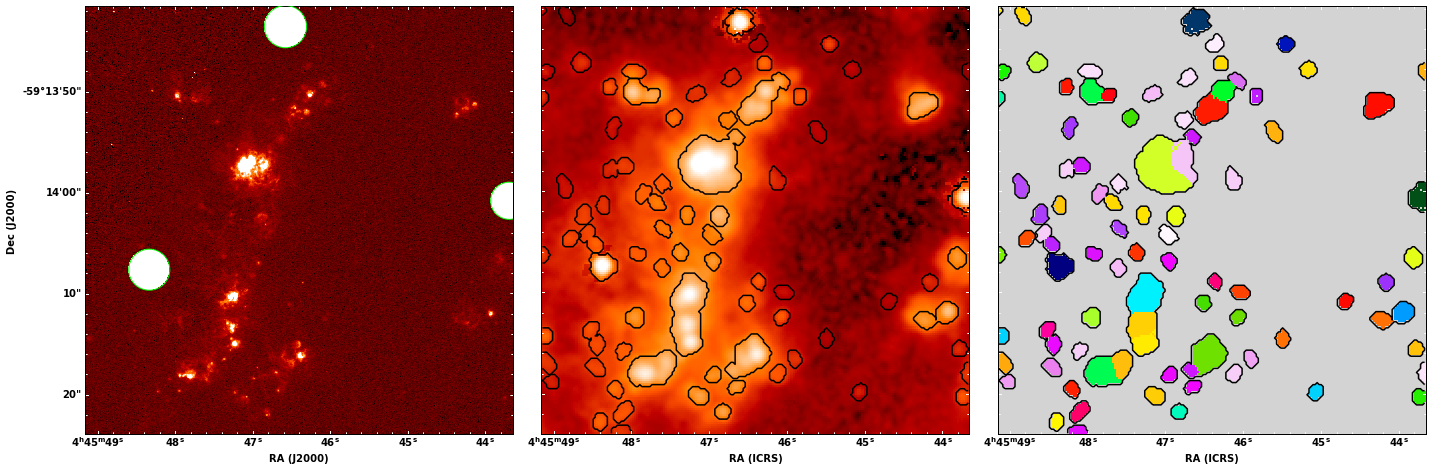

In [10]:
"""Quick check"""
"""Plotting the index map for checking"""

hdu_nebcat.data[hdu_nebcat.data==-1] = np.nan

fig = plt.figure(figsize=(20,20))
ax1 = aplpy.FITSFigure(hdu, figure=fig, subplot=(1,3,1))
ax2 = aplpy.FITSFigure(hdu_muse, figure=fig, subplot=(1,3,2))
ax3 = aplpy.FITSFigure(hdu_nebcat, figure=fig, subplot=(1,3,3))

ax1.show_colorscale(cmap='gist_heat', stretch='sqrt')
ax2.show_colorscale(cmap='gist_heat', stretch='sqrt')
ax3.show_colorscale(cmap='gist_ncar', stretch='sqrt')

ax3.set_nan_color('lightgrey')

ax2.tick_labels.hide_y()
ax3.tick_labels.hide_y()

ax2.axis_labels.hide_y()
ax3.axis_labels.hide_y()

ax1.show_regions('./saturatedregions.reg')

hdu_nebcat.data = np.nan_to_num(hdu_nebcat.data, nan=-1) 

# std = stats.mad_std(hdu.data*3, ignore_nan=True)
# ax1.show_contour(hdu, levels=[std], colors='C1', linestyles='-', smooth=1)
ax2.show_contour(hdu_nebcat, levels=[-1], colors='black', linestyles='-')
ax3.show_contour(hdu_nebcat, levels=[-1], colors='black', linestyles='-')

fig.tight_layout()
fig.savefig('./cutouts.pdf', bbox_inches='tight', dpi=300)